# BCS Testing with various etas and various upits

This notebook constructs a PC surrogate for Genz functions using random sampling and regression, giving the RMS error bewteen the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *
import PyUQTk.uqtkarray as uqtkarray

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

Fixing order, dimension

In [2]:
nord = 5           # Order of the PCE

pc_type = "LU"     # Polynomial type
ndim = 2

pc_alpha = 0.0     # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

c_opt='seq'
sigma = np.array([1.e-08]) # inital noise variance; updated in BCS
model='LU'
nSam=10000

## Define Coefficients

In [3]:
# polynomial goal
poly = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
npce_full=poly.GetNumberPCTerms()

# sequence of increasing integers
if (c_opt=="seq"):
    coef=np.array([1/(i+1) for i in range(npce_full)])
    
# sequence of increasing integers alternating with zero    
elif (c_opt=="alt"):
    coef=np.zeros(npce_full)
    for i in range(npce_full):
        if (i%2==0):
            coef[i]=1/(i+1)

## Training and Testing Points

In [4]:
nTest=int(npce_full*2)
rng = qmc.LatinHypercube(d=ndim, seed=42)

x_tr=2*rng.random(n=nTest)-1 #[-1,1]
if (model=='LU'):
    y_tr=pce_tools.UQTkEvaluatePCE(poly, coef, x_tr)
else:
    y_tr=func(x_tr,model,np.ones(ndim+1))
    
x_test=2*rng.random(n=nSam)-1

if (model=='LU'):
    y_test=pce_tools.UQTkEvaluatePCE(poly, coef, x_test)
else:
    y_test=func(x_test, model, np.ones(ndim+1))

## Collecting Errors

We loop through different etas and numbers of up-iterations to feed into BCS and obtain the RMSE.

In [11]:
etas=[.1, .015, .01, .02, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
neta=len(etas)
max_upit = nord

# arrays to store error statistics for each dimension
mean_test_errors=np.zeros((max_upit, neta))
std_test_errors=np.zeros((max_upit, neta))

# loop through each dimension
for upit in range(max_upit):
    
    # Create PC object
    pc_start = uqtkpce.PCSet("NISPnoq", nord-upit, ndim, pc_type, pc_alpha, pc_beta)
    
    for j, eta in enumerate(etas):
        print("eta", eta)   

        # list to store stats for the 10 trials
        RMSE_list=[]
        RMSE_test_list=[]

        for i in range(10):
           ### Training
            c_k, pc_model_final = pce_tools.UQTkBCS(pc_start, y_tr, x_tr, sigma, eta, upit)

            pce_evals_train=pce_tools.UQTkEvaluatePCE(pc_model_final, c_k, x_tr)

            MSE = np.square(np.subtract(y_tr, pce_evals_train)).mean()
            RMSE=math.sqrt(MSE)
            RMSE_list.append(RMSE/np.linalg.norm(y_test))
            if (math.isnan(RMSE)):
                print(c_k)
            ### Testing

            pce_evals_test=pce_tools.UQTkEvaluatePCE(pc_model_final, c_k, x_test)

            # metrics
            MSE_test = np.square(np.subtract(y_test,pce_evals_test)).mean()
            RMSE_test_list.append(math.sqrt(MSE_test)/np.linalg.norm(y_test))
            print("RMSE:", math.sqrt(MSE_test))
       
        # add the results of the 10 trials   
        mean_test_errors[upit][j]=np.array(RMSE_test_list).mean()
        std_test_errors[upit][j]=np.std(np.array(RMSE_test_list))

eta 0.1
RMSE: 0.14131857345798796
eta 0.015
RMSE: 0.08325938115878886
eta 0.01
RMSE: 0.08325938115878886
eta 0.02
RMSE: 0.14131857345798796
eta 0.001
RMSE: 0.061537783602863695
eta 0.0001
RMSE: 0.037041070076694875
eta 1e-05
RMSE: 6.779513015851161e-07
eta 1e-06
RMSE: 6.779513015851161e-07
eta 1e-07
RMSE: 6.779513015851161e-07
eta 1e-08
RMSE: 6.779513015851161e-07
eta 1e-09
RMSE: 4.453326757814076e-07
eta 1e-10
RMSE: 4.453326757814076e-07
eta 1e-11
RMSE: 8.445891617140851e-07
eta 1e-12
RMSE: 8.279634503659196e-07
eta 1e-13
RMSE: 8.284616706065865e-07
eta 1e-14
RMSE: 8.284616706065865e-07
eta 1e-15
RMSE: 8.284616706065865e-07
eta 0.1
RMSE: 0.14200459407900545
eta 0.015
RMSE: 0.08348479890889687
eta 0.01
RMSE: 0.08348479890889687
eta 0.02
RMSE: 0.14200459407900545
eta 0.001
RMSE: 0.06286334340510857
eta 0.0001
RMSE: 0.035893383308392
eta 1e-05
RMSE: 0.0243440064482466
eta 1e-06
RMSE: 0.025449542135066283
eta 1e-07
RMSE: 0.02904562889133393
eta 1e-08
RMSE: 0.029045628798191638
eta 1e-09
R

## Summary

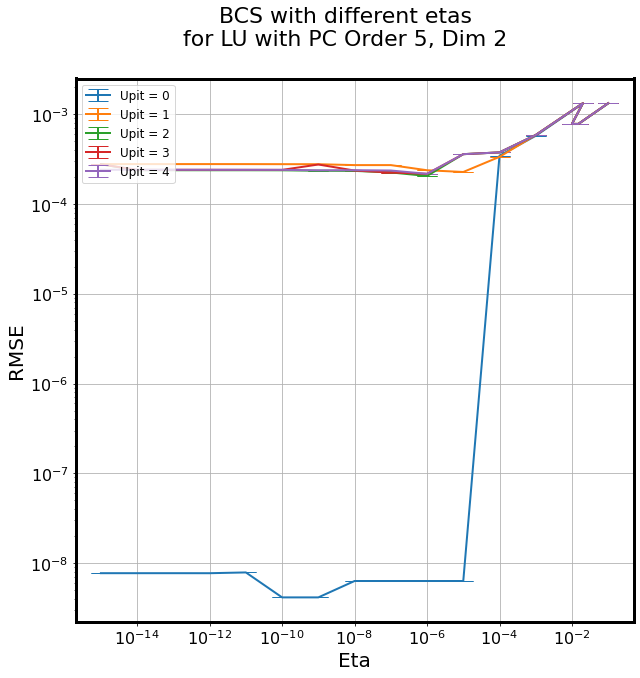

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot Error Data
for i in range(max_upit):
    plt.errorbar(etas, mean_test_errors[i], yerr=std_test_errors[i], xerr=None, linewidth=2, markersize=8, capsize=10, label=('Upit = '+str(i)))
    
# Label Axes
plt.xlabel("Eta",fontsize=20)
plt.ylabel("RMSE",fontsize=20)

# Create legend
plt.legend(loc='upper left')

# Add title
fig.suptitle("BCS with different etas\nfor %s with\
 PC Order %s, Dim %s"%(model, str(nord), str(ndim)), fontsize=22)

# Change y scale
plt.xscale('log')
plt.yscale('log')

#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 